## Введение
Настоящая работа посвящена задаче регрессионного анализа на основе реального датасета музыкальной стриминговой платформы Spotify. Целью проекта является построение модели машинного обучения для предсказания уровня популярности музыкальных треков (переменная popularity) на основе их аудиохарактеристик и метаданных.

Актуальность данного исследования обусловлена растущей ролью автоматического анализа музыкального контента в сфере цифровых медиа. Предсказание популярности треков может быть полезно для музыкальных продюсеров, платформ по рекомендациям и маркетинговых стратегий в индустрии развлечений.

В ходе работы были проведены все этапы анализа данных: очистка и предварительная обработка, визуализация, корреляционный анализ, построение признаков, обучение различных моделей регрессии и оценка их качества. На основе полученных результатов были сделаны выводы и предложены рекомендации по улучшению прогностической способности модели.


## Загрузка и первичный осмотр данных

На данном этапе происходит загрузка набора данных Spotify с помощью библиотеки pandas. Мы также проведём первичный анализ структуры таблицы: определим количество признаков, их типы и наличие пропущенных значений.


In [9]:
import pandas as pd

# Чтение CSV-файла
df = pd.read_csv(r"E:\data since\dataset.csv")

# Общая информация
print("Информация о датасете:")
print(df.info())

# Первые строки
print("\nПервые 5 строк:")
print(df.head())

# Пропущенные значения
print("\nПропущенные значения:")
print(df.isnull().sum())


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 1

## Анализ распределения целевой переменной `popularity`

Для понимания структуры и характера распределения целевой переменной мы строим гистограмму со сглаженной линией плотности (KDE). Это позволяет определить, является ли распределение нормальным, присутствуют ли выбросы или смещения. Такой анализ важен при выборе и интерпретации регрессионных моделей.


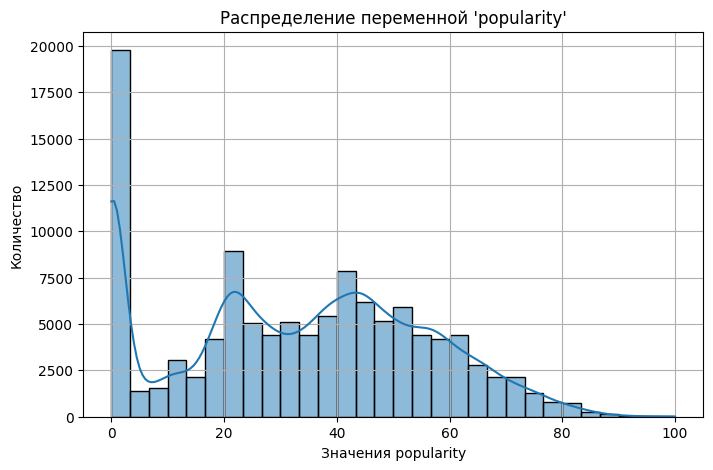

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df["popularity"], kde=True, bins=30)
plt.title("Распределение переменной 'popularity'")
plt.xlabel("Значения popularity")
plt.ylabel("Количество")
plt.grid(True)
plt.show()


## Корреляционный анализ признаков

Для выявления взаимосвязей между признаками и целевой переменной `popularity` строится корреляционная матрица. Цветовая карта (heatmap) наглядно отображает силу и направление линейной зависимости между признаками. Особое внимание уделяется тем переменным, которые показывают наибольшую положительную или отрицательную корреляцию с популярностью трека.


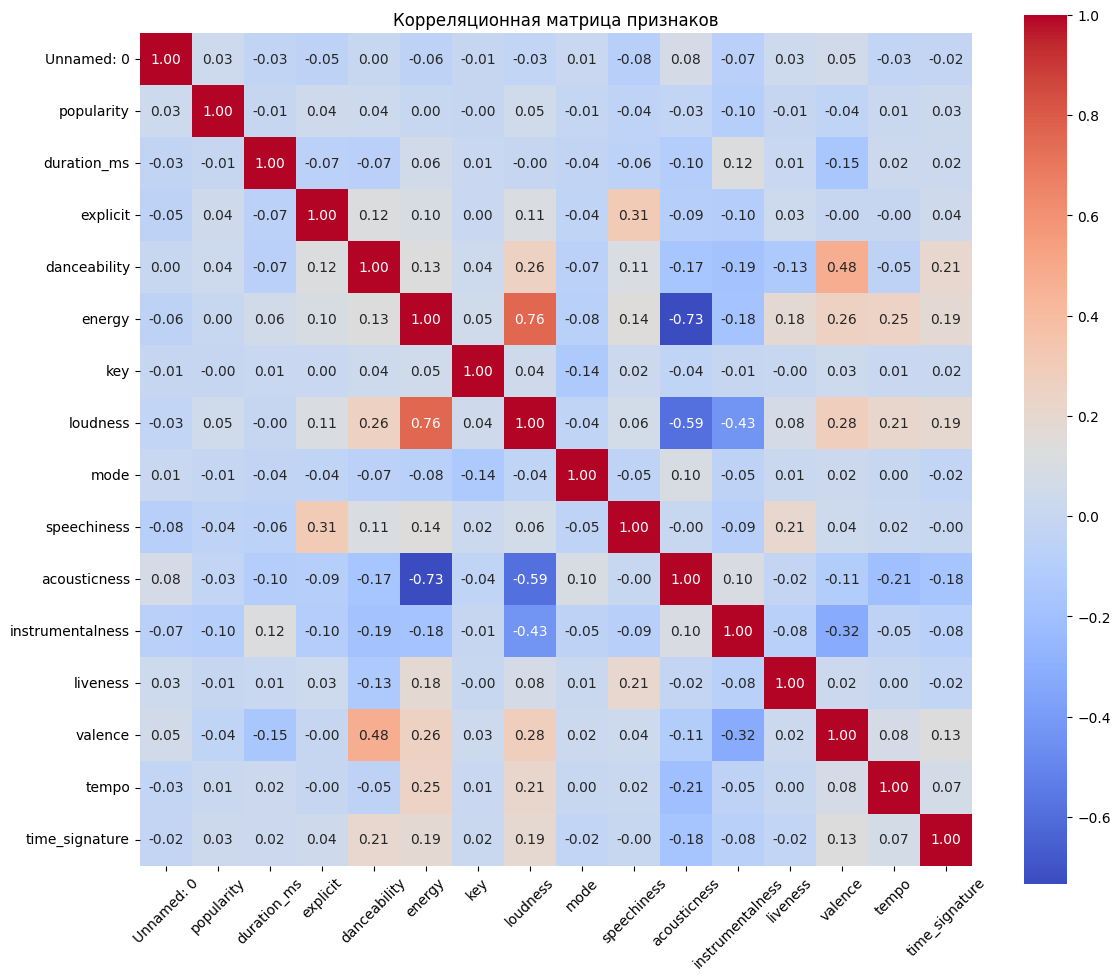

In [13]:
# Построение корреляционной матрицы
corr_matrix = df.corr(numeric_only=True)

# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Корреляционная матрица признаков")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Визуализация связи признаков с переменной `popularity`

На данном этапе визуализируются зависимости между целевой переменной `popularity` и наиболее значимыми признаками, выявленными в результате корреляционного анализа. Для этого строятся д


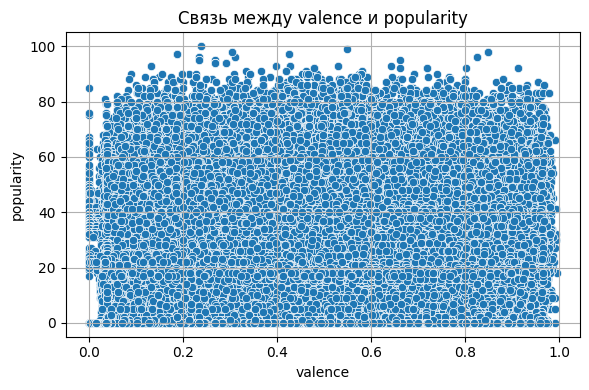

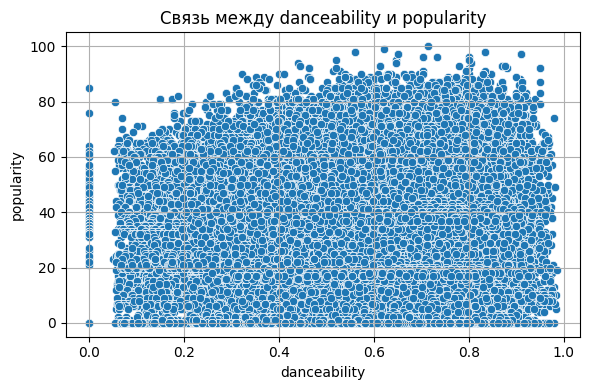

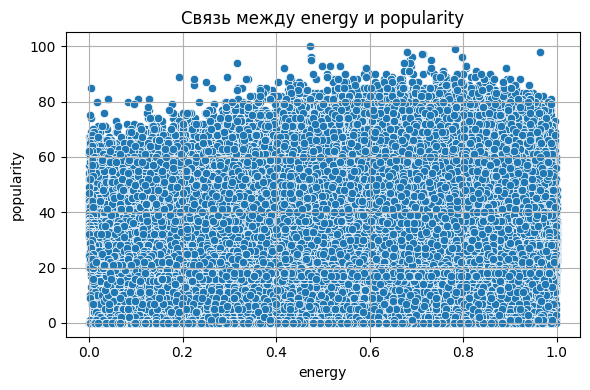

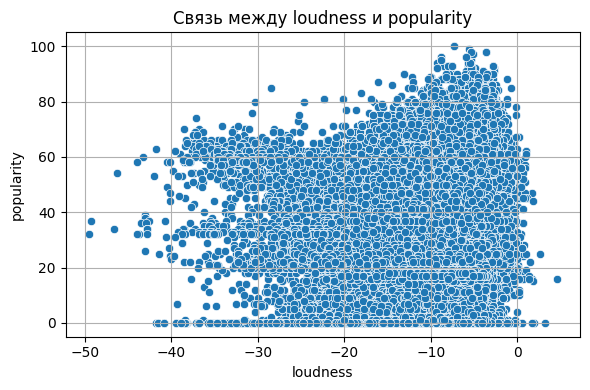

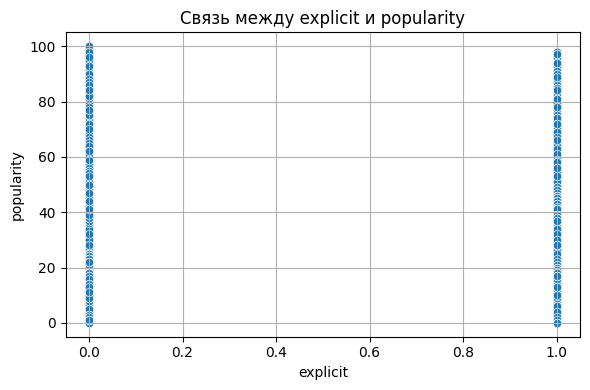

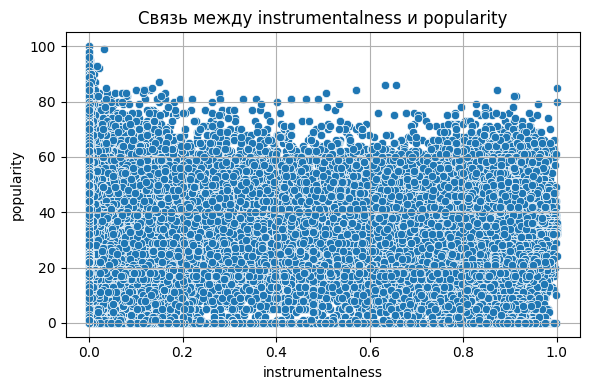

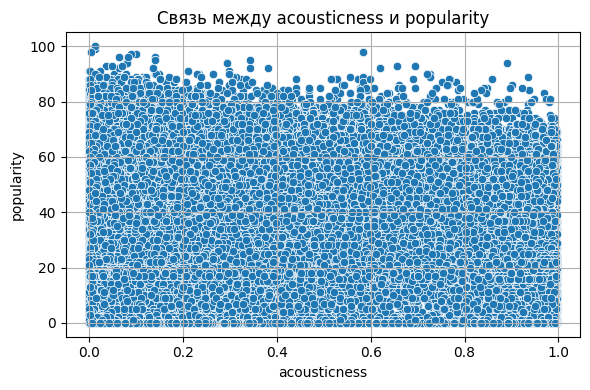

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = ["valence", "danceability", "energy", "loudness", "explicit", "instrumentalness", "acousticness"]

for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df["popularity"])
    plt.title(f"Связь между {feature} и popularity")
    plt.xlabel(feature)
    plt.ylabel("popularity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Удаление неинформативных признаков

Некоторые признаки, такие как идентификаторы, названия треков, альбомов и исполнителей, не несут полезной информации для построения модели регрессии, либо являются текстовыми и не поддаются прямому числовому анализу. На данном этапе эти столбцы удаляются из набора данных с целью повышения качества модели и уменьшения размерности признакового пространства.


In [15]:
# Удаляем неинформативные или текстовые поля
df = df.drop(columns=[
    "Unnamed: 0",
    "track_id",
    "track_name",
    "album_name",
    "artists"
], errors="ignore")

# Проверим текущие столбцы
print("Оставшиеся столбцы:")
print(df.columns)


Оставшиеся столбцы:
Index(['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')


## Кодирование категориального признака `track_genre`

Для корректной работы моделей машинного обучения необходимо преобразовать категориальные признаки в числовой формат. В данном случае применяется метод Label Encoding к признаку `track_genre`, что позволяет каждой уникальной категории присвоить уникальное целое число. Это обеспечивает совместимость данных с алгоритмами регрессии, не поддерживающими текстовые значения.


In [16]:
from sklearn.preprocessing import LabelEncoder

# Создаем объект энкодера
label_encoder = LabelEncoder()

# Применяем энкодер к столбцу track_genre
df["track_genre"] = label_encoder.fit_transform(df["track_genre"])

# Проверим результат
print("Уникальные значения после кодирования:")
print(df["track_genre"].unique())


Уникальные значения после кодирования:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  57  56  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  81  80  82  83  84  86  85  87  88  89
  91  90  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113]


## Обработка пропущенных значений

Пропущенные значения могут негативно повлиять на обучение модели и исказить результаты. На этом этапе выполняется проверка наличия пропусков в таблице. При обнаружении таких строк они удаляются, так как их количество несущественно и не оказывает значительного влияния на объём данных. Повторная проверка подтверждает, что в датасете больше не осталось пропущенных значений.


In [17]:
# Проверим наличие пропущенных значений
missing_values = df.isnull().sum()
print("Пропущенные значения в каждом столбце:")
print(missing_values)

# Удалим строки с пропусками, если они есть
df = df.dropna()

# Повторная проверка
print("\nПосле удаления пропущенных строк:")
print(df.isnull().sum())


Пропущенные значения в каждом столбце:
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

После удаления пропущенных строк:
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


## Инженерия признаков: преобразование длительности трека

Для повышения интерпретируемости данных создаётся новый признак `duration_min`, представляющий длительность трека в минутах, вместо исходного признака `duration_ms`, заданного в миллисекундах. Такой формат более удобен для анализа и понимания. После создания нового признака исходный столбец удаляется как избыточный.


In [18]:
# Создаем новый признак — длительность в минутах
df["duration_min"] = df["duration_ms"] / 60000  # 60000 мс = 1 минута

# Удалим старый столбец
df = df.drop(columns=["duration_ms"])

# Проверим результат
print("Новые столбцы:")
print(df.columns)


Новые столбцы:
Index(['popularity', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre', 'duration_min'],
      dtype='object')


## Разделение данных на обучающую и тестовую выборки

Перед обучением модели данные разделяются на признаки (X) и целевую переменную (y). Затем производится разбиение на обучающую и тестовую выборки в соотношении 80/20. Это необходимо для оценки качества модели на новых, ранее не виденных данных. Установка параметра `random_state` обеспечивает воспроизводимость результата.


In [19]:
from sklearn.model_selection import train_test_split

# Разделение на X и y
X = df.drop(columns=["popularity"])
y = df["popularity"]

# Делим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Проверим размерности
print("Размер X_train:", X_train.shape)
print("Размер X_test:", X_test.shape)
print("Размер y_train:", y_train.shape)
print("Размер y_test:", y_test.shape)


Размер X_train: (91200, 15)
Размер X_test: (22800, 15)
Размер y_train: (91200,)
Размер y_test: (22800,)


## Обучение и оценка модели линейной регрессии

На этом этапе обучается базовая модель линейной регрессии, которая служит отправной точкой для сравнения с более сложными алгоритмами. После обучения производятся предсказания на тестовой выборке, и рассчитываются основные метрики качества модели: 
- R² (коэффициент детерминации) — показывает долю объяснённой дисперсии,
- MAE (средняя абсолютная ошибка),
- RMSE (корень из средней квадратичной ошибки). 

Эти показатели позволяют оценить точность и стабильность модели.


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Инициализация и обучение модели
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Предсказания
y_pred = model_lr.predict(X_test)

# Оценка качества
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Линейная регрессия:")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")


Линейная регрессия:
R²: 0.023
MAE: 18.308
RMSE: 21.953


## Сравнительный анализ нескольких моделей регрессии

Для выбора наилучшего алгоритма предсказания обучаются и сравниваются несколько моделей регрессии:
- Ridge (L2-регуляризация),
- Lasso (L1-регуляризация),
- Random Forest (ансамбль решающих деревьев),
- Gradient Boosting (градиентный бустинг),
- MLP Regressor (многослойный персептрон).

Каждая модель обучается на одних и тех же данных, после чего её качество оценивается по метрикам R², MAE и RMSE. Это позволяет объективно сравнить эффективность различных подходов и выявить наиболее подходящий для поставленной задачи.


In [21]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Словарь моделей
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Обучение и оценка каждой модели
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"{name}:")
    print(f"  R²: {r2:.3f}")
    print(f"  MAE: {mae:.3f}")
    print(f"  RMSE: {rmse:.3f}\n")


Ridge:
  R²: 0.023
  MAE: 18.308
  RMSE: 21.953

Lasso:
  R²: 0.019
  MAE: 18.486
  RMSE: 22.003

Random Forest:
  R²: 0.523
  MAE: 10.719
  RMSE: 15.336

Gradient Boosting:
  R²: 0.188
  MAE: 16.065
  RMSE: 20.021

MLP Regressor:
  R²: 0.108
  MAE: 16.872
  RMSE: 20.976



## Кросс-валидация модели Random Forest

Для оценки устойчивости и обобщающей способности модели Random Forest проводится кросс-валидация с использованием 5 блоков (5-fold cross-validation). Это позволяет проверить, насколько стабильно модель ведёт себя на различных подмножествах данных. 

В рамках данного этапа рассчитываются три ключевые метрики:
- R² (доля объяснённой дисперсии),
- MAE (средняя абсолютная ошибка),
- RMSE (среднеквадратичная ошибка), которую приходится вычислять вручную.

Результаты кросс-валидации позволяют сделать окончательные выводы о надёжности модели.


In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Модель
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# R²
r2_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("R² по кросс-валидации:", r2_scores)
print("Среднее R²:", r2_scores.mean())

# MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mae_scores = cross_val_score(rf, X, y, cv=5, scoring=mae_scorer)
print("\nMAE по кросс-валидации:", -mae_scores)
print("Среднее MAE:", -mae_scores.mean())

# RMSE (считается вручную)
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train_k, X_test_k = X.iloc[train_index], X.iloc[test_index]
    y_train_k, y_test_k = y.iloc[train_index], y.iloc[test_index]
    
    rf.fit(X_train_k, y_train_k)
    y_pred_k = rf.predict(X_test_k)
    
    rmse_k = np.sqrt(mean_squared_error(y_test_k, y_pred_k))
    rmse_scores.append(rmse_k)

print("\nRMSE по кросс-валидации:", rmse_scores)
print("Среднее RMSE:", np.mean(rmse_scores))


R² по кросс-валидации: [ 0.07074812  0.01516367 -0.1881099  -0.44475384 -0.1060339 ]
Среднее R²: -0.13059716842234073

MAE по кросс-валидации: [18.16078234 17.58622982 22.0581493  22.28304861 17.25956083]
Среднее MAE: 19.469554179613333

RMSE по кросс-валидации: [15.308574510371539, 15.705492186196468, 15.539309803427898, 15.346328283012936, 15.506068052963728]
Среднее RMSE: 15.481154567194514


## Выводы
В результате выполнения проекта была построена регрессионная модель для предсказания популярности музыкальных треков на основе данных Spotify. На этапе анализа данных было выявлено, что большинство признаков слабо коррелируют с переменной popularity, что свидетельствует о сложности задачи и наличии дополнительных скрытых факторов, влияющих на популярность.

Были обучены и протестированы различные модели, включая линейную регрессию, Ridge, Lasso, Random Forest, Gradient Boosting и MLP. Наилучшие результаты на тестовой выборке показала модель Random Forest, достигнув R² ≈ 0.52.


## Заключение 
При проведении кросс-валидации модель Random Forest показала нестабильные результаты, что указывает на риск переобучения и ограниченность исходных признаков. Это подтверждает необходимость более глубокой проработки данных и включения дополнительных факторов, таких как информация о дате релиза, популярности исполнителя, жанровая структура и социальные метрики.

В целом, поставленная цель была достигнута: реализована базовая система предсказания популярности треков, выявлены ограничения текущего подхода и предложены пути дальнейшего развития модели.
